## 6 July 2018
-- Laurin Gray

Making a 3-sigma curve down a CMD. We flag any object rightward of the 3-sigma line "of interest". If a source is flagged in multiple CMDs, we can be more confident that it is an AGB star.

The approach in this notebook is to sort y-values, x-values, error values, and IDs into separate bins/arrays, grouped by magnitude ranges. We sort by magnitude because as the source becomes dimmer, the error associated with it increases. We determine the 3-sigma value for each range, and an average line down the main vertical branch to be 3-sigma away from. We then identify any value that is higher than the 3-sigma boundary for the region it falls into and place the corresponding ID into a new array, which can be compared to other arrays to determine which ones are flagged in multiple CMDs.

This notebook is to determine a better way to group the datasets, that doesn't involve individually naming each set.  Ideally this will make it much easier to build a function to group the data, and do the complete analysis of the notebook, so that we can perform it on several other CMDs.

The data comes from the catalog of Spitzer sources of Khan et al. (2015), matched with sources from Whitelock et al. (2013) in CasJobs.  In this notebook, we are working with the K vs K-[3.6] CMD.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde

In [2]:
# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('~/Documents/Phot_data/CMDparameters26June2018_lauringray.csv')

In [3]:
# Create all color cuts needed for plotting

phot_data['threesixMINUSfourfive'] = phot_data.k36mag.values - phot_data.k45mag.values
phot_data['threesixMINUSfiveeight'] = phot_data.k36mag.values - phot_data.k58mag.values
phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
phot_data['threesixMINUStwentyfour'] = phot_data.k36mag.values - phot_data.k24mag.values
#
phot_data['fourfiveMINUSfiveeight'] = phot_data.k45mag.values - phot_data.k58mag.values
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
phot_data['fourfiveMINUStwentyfour'] = phot_data.k45mag.values - phot_data.k24mag.values
#
phot_data['fiveeightMINUSeightzero'] = phot_data.k58mag.values - phot_data.k80mag.values
phot_data['fiveeightMINUStwentyfour'] = phot_data.k58mag.values - phot_data.k24mag.values
#
phot_data['eightzeroMINUStwentyfour'] = phot_data.k80mag.values - phot_data.k24mag.values
#
phot_data['jMINUSthreesix'] = phot_data.Jmag.values - phot_data.k36mag.values
phot_data['jMINUSfourfive'] = phot_data.Jmag.values - phot_data.k45mag.values
phot_data['jMINUSfiveeight'] = phot_data.Jmag.values - phot_data.k58mag.values
phot_data['jMINUSeightzero'] = phot_data.Jmag.values - phot_data.k80mag.values
phot_data['jMINUStwentyfour'] = phot_data.Jmag.values - phot_data.k24mag.values
#
phot_data['hMINUSthreesix'] = phot_data.Hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.Hmag.values - phot_data.k45mag.values
phot_data['hMINUSfiveeight'] = phot_data.Hmag.values - phot_data.k58mag.values
phot_data['hMINUSeightzero'] = phot_data.Hmag.values - phot_data.k80mag.values
phot_data['hMINUStwentyfour'] = phot_data.Hmag.values - phot_data.k24mag.values
#
phot_data['kMINUSthreesix'] = phot_data.Kmag.values - phot_data.k36mag.values
phot_data['kMINUSfourfive'] = phot_data.Kmag.values - phot_data.k45mag.values
phot_data['kMINUSfiveeight'] = phot_data.Kmag.values - phot_data.k58mag.values
phot_data['kMINUSeightzero'] = phot_data.Kmag.values - phot_data.k80mag.values
phot_data['kMINUStwentyfour'] = phot_data.Kmag.values - phot_data.k24mag.values

In [4]:
# Combine errors

# We want the horizontal error values, so we combine the errors for the two values being subtracted 
# to get the largest possible error bars

phot_data['e_kMINUSthreesix'] = phot_data.eKmag.values + phot_data.e36mag.values

In [5]:
# Some values in the tables are +/- 9999, due to null data from combining the tables, 
# which throws off the color scaling.  We wish to exclude these values, 
# which we do by cutting to only include values in the range -500:500

filter_phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]

In [6]:
# Creating bins

# bin_size, y1, and y2 will be inputs for an eventual binning function.  
# It will be important for the user to make sure that the range and bin size 
# they choose will generate a whole number- they will recieve an error otherwise.

bin_size = 0.1
y1 = 11.5
y2 = 18.5
n_bins = (y2 - y1)/bin_size
#print(n_bins)

if n_bins%1 == 0:
    n_bins = int(n_bins)
else:
    print("Error: n_bins is not a whole number!  Choose a different range or bin size.")

In [7]:
y_bins = [[] for x in range(0,n_bins)]
x_bins = [[] for x in range(0,n_bins)]
e_bins = [[] for x in range(0,n_bins)]
c_bins = [[] for x in range(0,n_bins)]

#print(y_bins)

c=0 #row counter
for i in filter_phot_data.Kmag.values:
    k = 0 #bin counter
    y1 = 11.5
    while k < n_bins+1:
        if y1 <= i < y1+bin_size:
            y_bins[k].append(i)
            x_bins[k].append(filter_phot_data.kMINUSthreesix.values[c])
            e_bins[k].append(filter_phot_data.e_kMINUSthreesix.values[c])
            c_bins[k].append(phot_data.ID.values[c])
            y1 = y1+bin_size
            k = k+1
        else:
            y1 = y1+bin_size
            k = k+1
    c = c+1

I now have lists of the types of variables, which all contain lists of the variables in each grouping.  This should be much easier to manage as I can now access the index of the specified list.

In [8]:
#print(e_bins)

threesig = []
for i in e_bins:
    threesig.append(np.mean(i)*3)

#print(threesig)

# Note: if any bins are empty, will recieve a RuntimeWarning: Mean of empty slice.  
# This is fine, it just holds a nan value in that spot and won't plot a boundary there

/Users/lgray/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lgray/anaconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# determine the vertical mean

vert_lim = 15.0 # argument for eventual function

k_mean = []

c=0
for i in filter_phot_data.Kmag.values:
    if i < 15.0:
        k_mean.append(filter_phot_data.kMINUSthreesix.values[c])
        c = c+1
    else:
        c = c+1

bound = np.mean(k_mean)
stdev = np.std(k_mean)

left = bound - 3*stdev
right = bound + 3*stdev

clip = [] # sigma-clipped array
for k in k_mean:
    if left < k < right:
        clip.append(k)

boundary = np.mean(clip) #this is the average value of the points above K=15
#print(boundary)

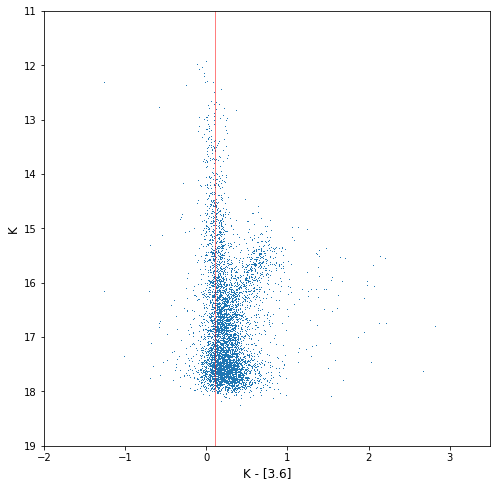

In [10]:
# check vertical line placement

# K vs. K-[3.6]
#
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.Kmag,',')
plt.xlim(-2.0, 3.5)
plt.ylim(19.0, 11.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)
plt.axvline(x=boundary, color='r', linewidth='0.5')
#plt.savefig('K_vs_K-[3.6]_plot.pdf')

In [11]:
# Now we shift regions of the vertical mean by 3-sigma

# make list of red limit values
redlim = []

for i in threesig:
    redlim.append(boundary+i)
    
#print(redlim)

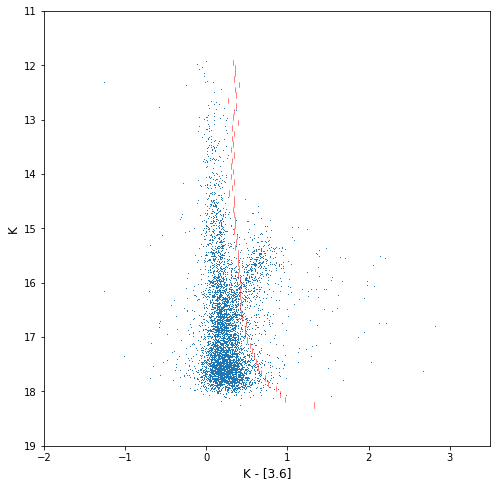

In [12]:
# Confirm shifted boundaries

plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.Kmag,',')
plt.xlim(-2.0, 3.5)
plt.ylim(19.0, 11.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)

y1 = 11.5 #start of first bin range
for x in redlim:
    plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth='0.5')
    y1 = y1 + bin_size

In [13]:
# Evaluate and flag points that are to the right of the red line for that region

kVS_kMINUSthreesix_points = [] #empty set to store IDs

k=0
for i in x_bins:
    coord = c_bins[k]
    c=0
    for x in i:
        if x > redlim[k]:
            kVS_kMINUSthreesix_points.append(coord[c])
            c=c+1
        else: 
            c=c+1
    k = k+1
            
print("Number of flagged points:", len(kVS_kMINUSthreesix_points))
#print("IDs of points:", kVS_kMINUSthreesix_points)

Number of flagged points: 662


In [14]:
# Visually confirm that the points are being marked correctly

red_x = []
red_y = []

k=0
for i in x_bins:
    c=0
    y_val = y_bins[k]
    for x in i:
        if x > redlim[k]:
            red_x.append(x)
            red_y.append(y_val[c])
            c=c+1
        else: 
            c=c+1
    k = k+1

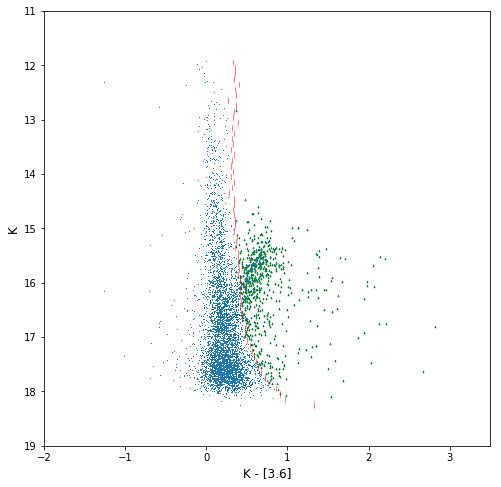

In [15]:
plt.figure(figsize=(8,8))
plt.plot(filter_phot_data.kMINUSthreesix,filter_phot_data.Kmag,',')
plt.xlim(-2.0, 3.5)
plt.ylim(19.0, 11.0)
plt.xlabel('K - [3.6]', size=12)
plt.ylabel('K', size=12)
plt.scatter(red_x, red_y, s=0.5, c='green')

y1 = 11.5 #start of first bin range
for x in redlim:
    plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth='0.5')
    y1 = y1 + bin_size

The next steps are:
1. Decide the best way to save the flagged points- I'm thinking put them in a file w/ each column from a different CMD
2. Create functions for:
    - Binning data (inputs: range, bin size, x-axis & y-axis data, error data; return: bins)
    - Computing vertical mean (inputs: y-magnitude limit, x & y data; return: boundary)
    - Creating 3-sigma line (inputs: boundary; return: redlim
    - Flagging points (inputs: name of dataset?)